In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import functions as fn
from networkx.algorithms import community
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

## Production Line - CCM

In [2]:
df_CCM = pd.read_csv('data/ccm_manipulated_347418.csv', header=None)
pd.read_csv('data/ccm_manipulated_347418.csv', names=fn.columns_CCM, header=None).head()

EVENT_ID SEQUENCE_ID  R_OS_ID PRODUCTION_LINE_NAME REFERENCE_DATE  \
0      8360         109   115587                 CCM1       13.12.16   
1      8359         109   115587                 CCM1       13.12.16   
2      8358         109   115587                 CCM1       13.12.16   
3      8357         109   115587                 CCM1       13.12.16   
4      8356         109   115587                 CCM1       13.12.16   

      PIECE_ID MATERIAL_ID MOLD_WIDTH   WIDTH  THICKNESS        WEIGHT  \
0  16000041-07      148513     #NAME?  1330.0         87  2.140000e+09   
1  16000041-06      148512     #NAME?  1330.0         87  2.140000e+09   
2  16000041-05      148511     #NAME?  1330.0         87  2.140000e+09   
3  16000041-03      148509     #NAME?  1330.0         87  2.140000e+09   
4  16000041-02      148508     #NAME?  1330.0         87  2.140000e+09   

         LENGTH     HEAT_ID  STEEL_GRADE_ID_INT  EXIT_TEMP  SLAB_TRANSITION  
0  2.440000e+09  16000041.0                26.0        0.0                0  
1  2.440000e+09  16000041.0                26.0        0.0                0  
2  2.440000e+09  16000041.0                26.0        0.0                0  
3  2.440000e+09  16000041.0                26.0        0.0                0  
4  2.440000e+09  16000041.0                26.0        0.0                0

In [3]:
data = df_CCM
features = [8,9] # input width and thickness
data[features].nunique()

8    141
9     33
dtype: int64

#### Count Check For Features

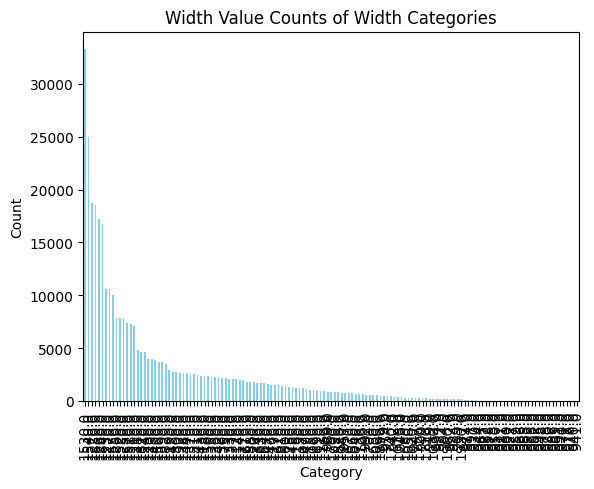

In [4]:
feature = features[0]
counts = data[feature].value_counts()
#print(counts.describe())
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
#plt.yticks(range(0, max(counts)+500, 250))
#plt.xticks([])
if feature == features[0]:
    plt.title('Width Value Counts of Width Categories')
elif feature == features[1]:
    plt.title('Thickness Value Counts of Thickness Categories')
#plt.title('Value Counts of Categories')
plt.show()

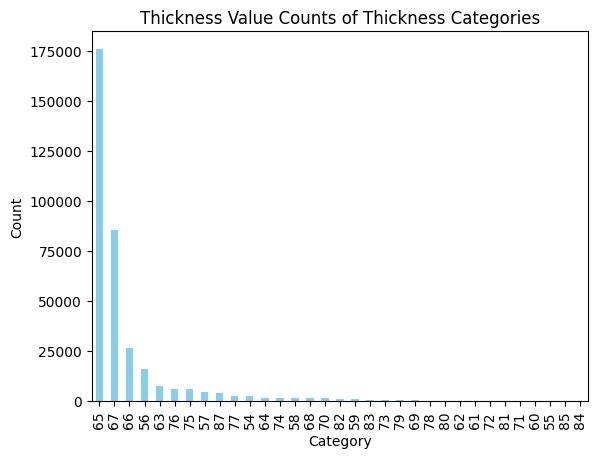

In [9]:
feature = features[1]
counts = data[feature].value_counts()
#print(counts.describe())
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
#plt.yticks(range(0, max(counts)+500, 250))
#plt.xticks([])
if feature == features[0]:
    plt.title('Width Value Counts of Width Categories')
elif feature == features[1]:
    plt.title('Thickness Value Counts of Thickness Categories')
#plt.title('Value Counts of Categories')
plt.show()

### Trials without Binning Schemes

In [13]:
lift_pairwise_width, elem_map_step = fn.calculate_lift_pairwise(data, bins_column=8, sequence_column=1,return_element_mapping=True)
lift_pairwise_thickness, elem_map_step = fn.calculate_lift_pairwise(data, bins_column=9, sequence_column=1,return_element_mapping=True)

adj_matrix_width = fn.create_adjacency_matrix(lift_pairwise_width, elem_map_step)
adj_matrix_thickness = fn.create_adjacency_matrix(lift_pairwise_thickness, elem_map_step)

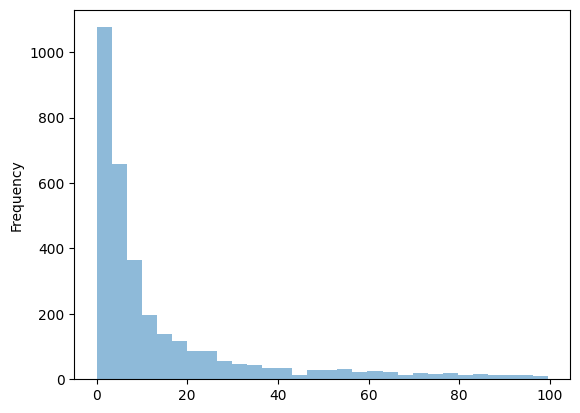

In [14]:
ax = lift_pairwise_width['lift_value'].apply(lambda x: x if x < 100 else None).plot.hist(bins=30, alpha=0.5)

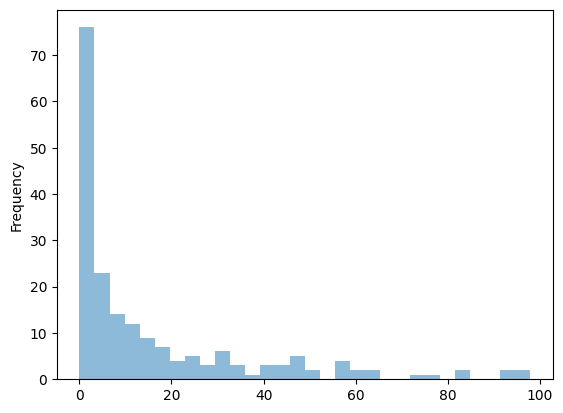

In [15]:
ax = lift_pairwise_thickness['lift_value'].apply(lambda x: x if x < 100 else None).plot.hist(bins=30, alpha=0.5)

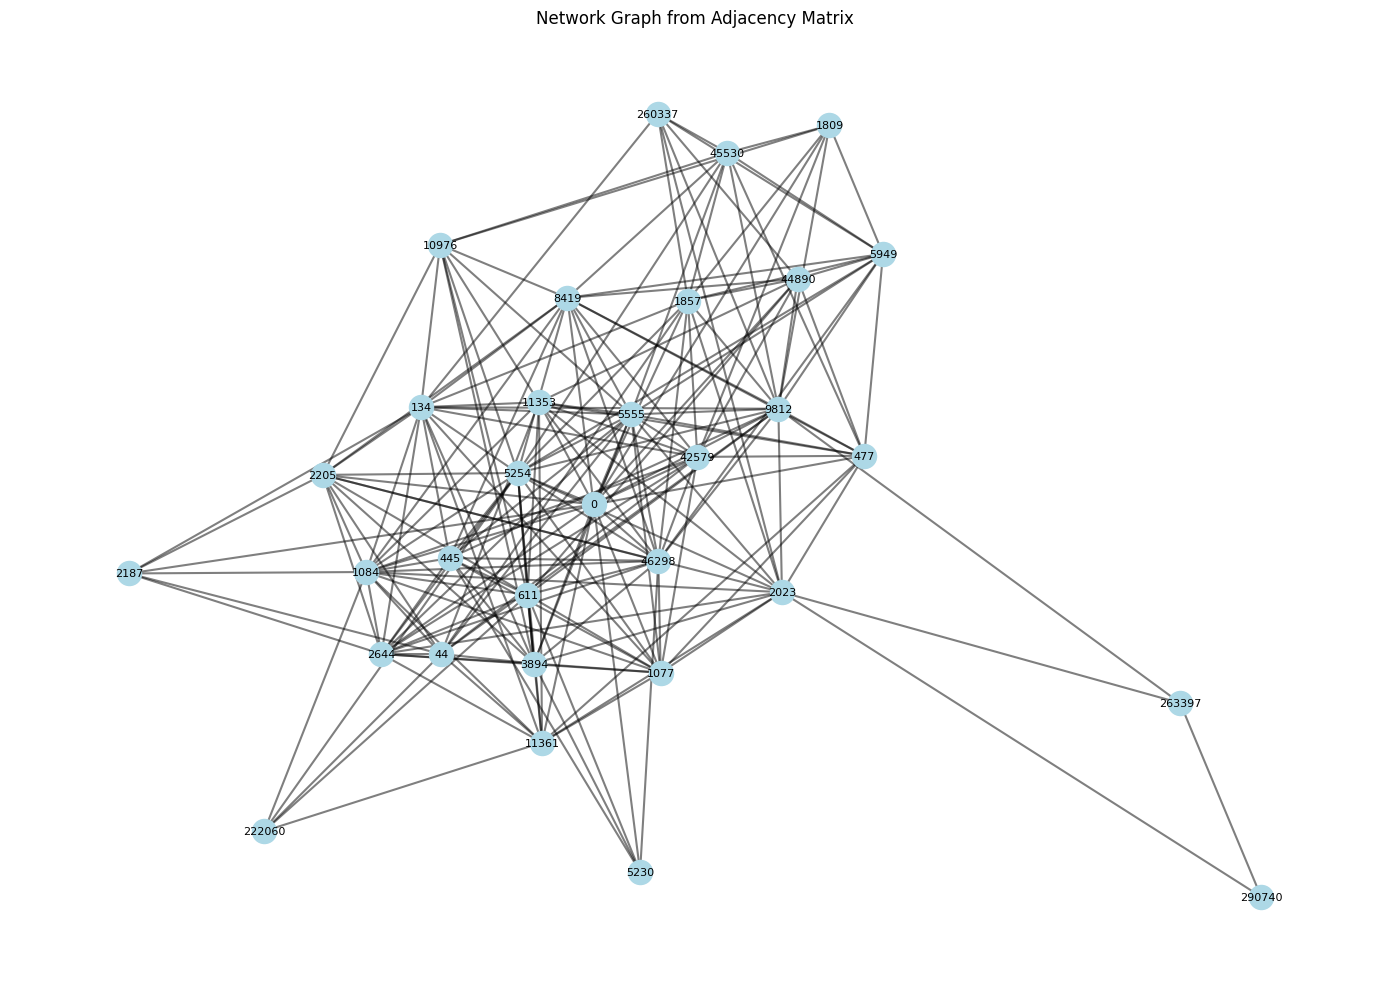

Number of nodes: 32
Number of edges: 196
Network density: 0.3952


In [19]:
#binary_matrix = adj_matrix_width.copy()
binary_matrix = adj_matrix_thickness.copy()
binary_matrix[binary_matrix < 1] = 0
binary_matrix[binary_matrix > 1] = 1
#binary_matrix

# Create a NetworkX graph from the binary adjacency matrix
G = nx.from_pandas_adjacency(binary_matrix)

#Remove self-loops (diagonal values of 1)
G.remove_edges_from(nx.selfloop_edges(G))

# Visualize the network
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network Graph from Adjacency Matrix")
plt.axis('off')
plt.tight_layout()
plt.show()

# Print network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# CCM check (matches): step size=5,  df.iloc[[94705,39836,318277], [2]] -> bins_fxd_step: (920, 925), (1895, 1900), (1915, 1920)

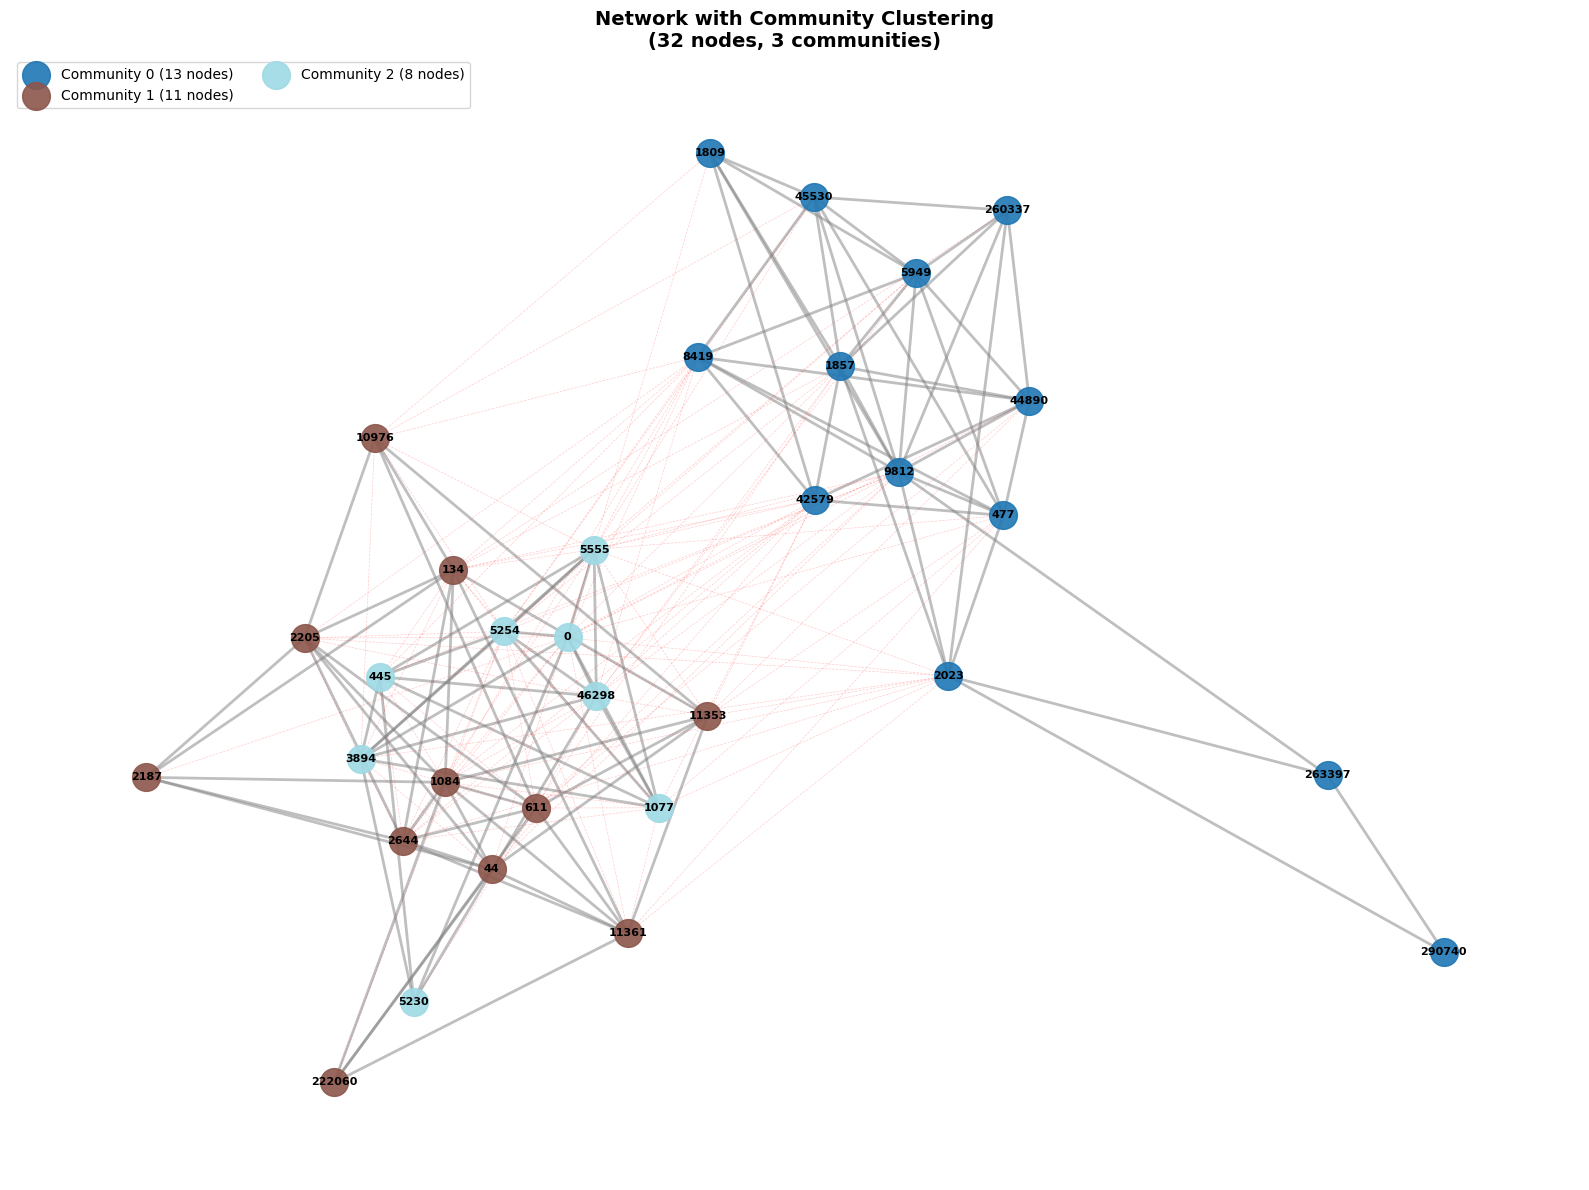

In [20]:
# Graph analysis with community detection and improved visualization

# Create graph
G = nx.from_pandas_adjacency(binary_matrix)
G.remove_edges_from(nx.selfloop_edges(G))

# Detect communities
communities_list = list(community.greedy_modularity_communities(G))

# Create node to community mapping
node_to_community = {}
for i, comm in enumerate(communities_list):
    for node in comm:
        node_to_community[node] = i

# Use spring layout with custom parameters to create tighter clusters
# Increase k to push nodes apart, but edges will pull community members together
pos = nx.spring_layout(G, k=1.0, iterations=100, seed=42, scale=2)

# Apply community-aware repositioning
# Move nodes closer to their community centroid
community_centers = {}
for i, comm in enumerate(communities_list):
    comm_nodes = list(comm)
    center_x = np.mean([pos[node][0] for node in comm_nodes])
    center_y = np.mean([pos[node][1] for node in comm_nodes])
    community_centers[i] = (center_x, center_y)

# Adjust node positions to be closer to community centers
for node in G.nodes():
    comm_id = node_to_community[node]
    center = community_centers[comm_id]
    # Move node 30% towards its community center
    pos[node] = (
        pos[node][0] * 0.7 + center[0] * 0.3,
        pos[node][1] * 0.7 + center[1] * 0.3
    )

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))

# Draw nodes colored by community (now spatially grouped)
colors = plt.cm.tab20(np.linspace(0, 1, len(communities_list)))
for i, comm in enumerate(communities_list):
    comm_nodes = list(comm)
    nx.draw_networkx_nodes(G, pos, nodelist=comm_nodes, 
                          node_color=[colors[i]], 
                          node_size=400, 
                          alpha=0.9, 
                          label=f'Community {i} ({len(comm)} nodes)',
                          ax=ax)

# Draw edges - distinguish internal vs external
internal_edges = []
external_edges = []
for u, v in G.edges():
    if node_to_community[u] == node_to_community[v]:
        internal_edges.append((u, v))
    else:
        external_edges.append((u, v))

# Draw internal edges (within communities) - darker and thicker
nx.draw_networkx_edges(G, pos, edgelist=internal_edges, 
                      alpha=0.5, width=2, 
                      edge_color='gray', ax=ax)

# Draw external edges (between communities) - lighter and thinner
nx.draw_networkx_edges(G, pos, edgelist=external_edges, 
                      alpha=0.2, width=0.5, 
                      edge_color='red', ax=ax, style='dashed')

nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)

ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.set_title(f"Network with Community Clustering\n({G.number_of_nodes()} nodes, {len(communities_list)} communities)", 
             fontsize=14, fontweight='bold')
ax.axis('off')
fig.tight_layout()
plt.show()

### Binning Schemes

Events can be grouped with a typical value interval, the so-called binning size. Binning generation can be performed in alternative ways, allowing us to put the hypothetically created constraints into practice.

There alternative ways of binning such as fixed steps or fixed counts (buckets). The former creates binning with defined step size, the latter forms bin data into groups with equal numbers of elements.

In [10]:
#data = df_CCM
feature = 8 # input width
#feature = 9 # input thickness
df = pd.DataFrame()
df['sequence_id'] = data[1]
df[feature] = data[feature]
df['bins_fxd_step'] = fn.binning_fxd_step(data[feature], 5)
df['bins_fxd_bucket'] = fn.binning_fxd_bucket(data[feature],108)
print('bins_fxd_step count:',df['bins_fxd_step'].nunique())
print('bins_fxd_bucket count:',df['bins_fxd_bucket'].nunique())
df
# select specific rows for testing
#df.iloc[[73,472,1213,9087], [0,2]]

bins_fxd_step count: 108
bins_fxd_bucket count: 108


sequence_id       8     bins_fxd_step bins_fxd_bucket
0              109  1330.0  [1330.0, 1335.0)     [1320-1330]
1              109  1330.0  [1330.0, 1335.0)     [1320-1330]
2              109  1330.0  [1330.0, 1335.0)     [1330-1350]
3              109  1330.0  [1330.0, 1335.0)     [1330-1350]
4              109  1330.0  [1330.0, 1335.0)     [1330-1350]
...            ...     ...               ...             ...
347413        4154  1530.0  [1530.0, 1535.0)     [1520-1530]
347414        4154  1530.0  [1530.0, 1535.0)     [1520-1530]
347415        4154  1530.0  [1530.0, 1535.0)     [1520-1530]
347416        4154  1530.0  [1530.0, 1535.0)     [1520-1530]
347417        4154  1530.0  [1530.0, 1535.0)     [1530-1540]

[347418 rows x 4 columns]

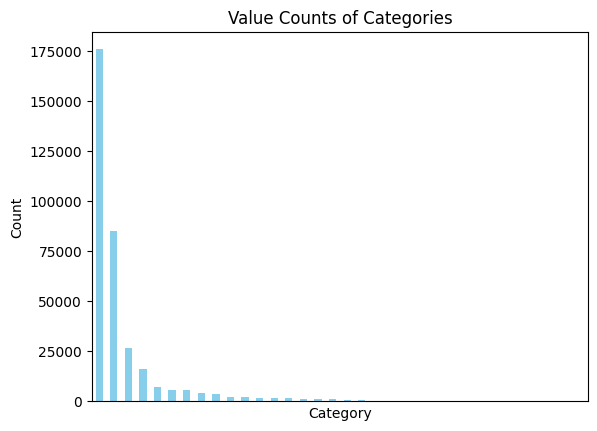

In [13]:
counts = df['bins_fxd_step'].value_counts()
#print(counts.describe())
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
#plt.yticks(range(0, max(counts)+500, 250))
plt.xticks([])
plt.title('Value Counts of Categories')
plt.show()

In [12]:
counts = df['bins_fxd_bucket'].value_counts()
print(counts.describe())
#counts.plot(kind='bar', color='skyblue')
#plt.xlabel('Category')
#plt.ylabel('Count')
#plt.yticks(range(0, max(counts)+500, 250))
#plt.xticks([])
#plt.title('Value Counts of Categories')
#plt.show()

count     108.000000
mean     3216.833333
std         1.732051
min      3199.000000
25%      3217.000000
50%      3217.000000
75%      3217.000000
max      3217.000000
Name: count, dtype: float64


The alternative binning generation methods mentioned above will let us derive two distinguished approaches to construct association networks.

#### Lift Measure

We extract the association rule from the set of production sequences to distinguish statistically unexpected occurrences from the non-random ones in production sequences and assess the complexity of production patterns.

The Lift can be computed as the ratio of pair items joint
probability divided by the multiplication of each item’s marginal probability as:

$$ Lift(A ↔ B) =  \frac{P(A, B)}{P(A) ∗ P(B)} $$

If the lift is higher than 1, B likely occurs when A occurs. If the lift is lower than 1, B unlikely occurs when A occurs.

In [15]:
# Calculate lift and get indices for both fixed-step bins and fixed-count buckets
lift_pairwise_step, elem_map_step = fn.calculate_lift_pairwise(df, bins_column='bins_fxd_step', return_element_mapping=True)
lift_pairwise_bucket, elem_map_bucket = fn.calculate_lift_pairwise(df, bins_column='bins_fxd_bucket', return_element_mapping=True)

# Build adjacency matrices
adj_matrix_step = fn.create_adjacency_matrix(lift_pairwise_step, elem_map_step)
adj_matrix_bucket = fn.create_adjacency_matrix(lift_pairwise_bucket, elem_map_bucket)

#lift_pairwise_step
#lift_pairwise.index.to_list()

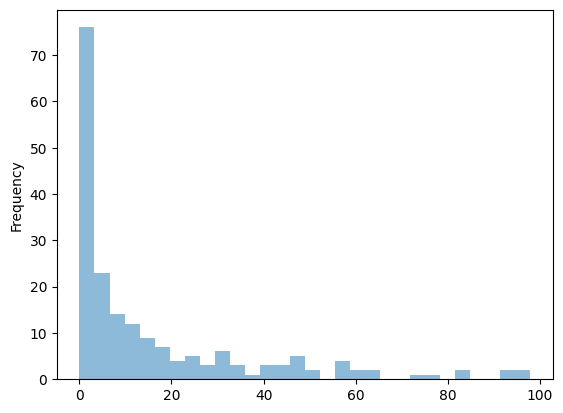

In [16]:
#histogram
ax = lift_pairwise_step['lift_value'].apply(lambda x: x if x < 100 else None).plot.hist(bins=30, alpha=0.5)
#ax = lift_pairwise_step['lift_value'].apply(lambda x: x if 0 < x < 60 else None).plot.hist(bins=30, alpha=0.5, logx=True, logy=True)

Characteristics:
- Right-Skewed, approaching zero
- Heavy concentration at low lift values (0-5)
- Long tail toward higher values
- High positive skewness (> 1.0)
- Median << Mean

What it means:
- High-Frequency Elements: Most element pairs have weak or random co-occurrence
- Most pairs have lift < 1 (appear together less often than random chance)
- A few rare pairs have strong associations
- Common elements occur independently; co-occurrence is mostly coincidental

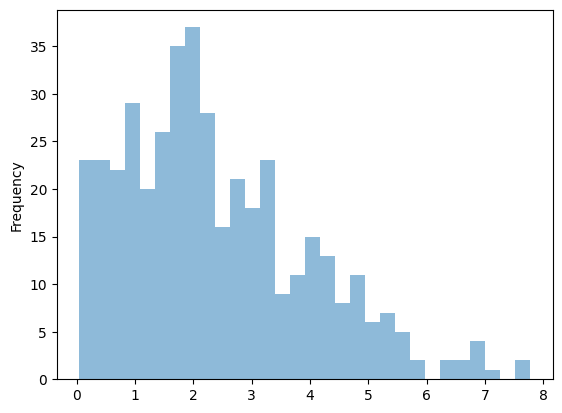

In [17]:
bx = lift_pairwise_bucket['lift_value'].apply(lambda x: x if x < 1000 else None).plot.hist(bins=30, alpha=0.5)
#bx = lift_pairwise_bucket['lift_value'].apply(lambda x: x if 0 < x < 5000 else None).plot.hist(bins=30, alpha=0.5, logx=True, logy=True)

Characteristics:
- Near-Normal, deviation from zero
- More centered distribution (peak around 2-3)
- Roughly symmetric around the mean
- Lower skewness (-0.5 to +0.5)
- Mean ≈ Median

What it means:
- Rare/Selective Elements: Most element pairs have meaningful associations
- Lift values are concentrated around 2-4 (strong positive associations)
- More consistent clustering behavior
- Rare elements form predictable, structured groups when they co-occur

### Network Analysis

Constructing FSS (Fixed Step Size) and FBS (Fixed Bucket Size) networks for the production events concerning technology-driven constraints and load-driven constraints underlie the developed hypothesis of this work: Non-random features of the association networks derived from these two approaches.

The first one, the FSS Network has graph nodes as binning groups with equal bin sizes. Manipulation of binning size allows us to aggregate events in different network nodes. 

The FBS Network is the second one where the network nodes are binning groups with an equal number of events per bin. Defining a typical bucket size for the network nodes results in arbitrary interval boundaries for each node, and it allows to control their population.

#### Graphs Generation

In [18]:
adj_matrix_step
# select specific pair
# lift_pairwise.loc[(lift_pairwise['element_A_row_idx'] == 0) & (lift_pairwise['element_B_row_idx'] == 5)]

0          44         134         445         477         611     \
0         1.000000   0.178963   0.677474    0.716522   24.557400    0.276242   
44        0.178963   1.000000   0.041483    0.357917    0.125150    0.127608   
134       0.677474   0.041483   1.000000    1.171113    0.776567    0.727024   
445       0.716522   0.357917   1.171113    1.000000    0.000000    7.323860   
477      24.557400   0.125150   0.776567    0.000000    1.000000    0.000000   
611       0.276242   0.127608   0.727024    7.323860    0.000000    1.000000   
1077      1.055611   0.597442   3.060590   40.048333   63.300100   10.111500   
1084      6.564233   3.740748  17.484867   32.960700    0.000000   41.050800   
1809     46.021450   0.000000   0.357400    0.000000    0.000000    0.000000   
1857     22.687000  11.899600   3.842500    0.000000    0.000000    0.000000   
2023      0.076956   0.009248   0.075996    0.469019    1.009840    0.247850   
2187    129.190100   5.706200  18.233900    0.000000    0.000000    0.000000   
2205     30.171613   4.030480  43.587386    0.000000    0.000000   13.353300   
2644     12.214300   4.376100  29.359960  104.928400    0.000000  158.848667   
3894     21.654700   7.756700  83.198925   32.263133    0.000000   26.047233   
5230     15.784900   0.485267   0.465900   56.039167    0.000000   30.044400   
5254      1.080000   0.597279   1.740617    1.998350    0.000000    4.463150   
5555      5.948767   2.472386  11.869030   12.851300  157.422567    0.000000   
5949      0.697600   0.167386   0.695357    0.000000    4.765500    0.178600   
8419      8.346033   0.458350   1.727200   15.695700   95.206300    0.591600   
9812     15.059850   3.393175   7.897900   17.422100   30.903600   12.279400   
10976     0.959600   0.756767   1.958487    0.000000    0.000000    6.877100   
11353     5.187477   2.307194   8.314675    0.000000   11.717600   25.151900   
11361     7.531459   4.536206  23.592600    0.000000  539.540100   72.568350   
42579     2.000400   1.544800   4.244400    0.000000  152.125300    0.000000   
44890     4.890900   0.157233   0.546500    0.000000   17.121150    3.081600   
45530     0.747200   0.062576   0.273127    0.000000    2.182200    0.291950   
46298     4.072550   0.158125   0.628986    1.980400    0.000000    2.048250   
222060    0.000000  76.935400   0.000000    0.000000    0.000000  216.843200   
260337    0.000000   0.262180   1.551500    0.000000    0.000000    0.000000   
263397    0.000000   0.000000   0.000000    0.000000    0.000000    0.000000   
290740    0.000000   0.000000   0.000000    0.000000    0.000000    0.000000   

            1077         1084        1809         1857    ...      11353   \
0         1.055611     6.564233    46.02145    22.687000  ...    5.187477   
44        0.597442     3.740748     0.00000    11.899600  ...    2.307194   
134       3.060590    17.484867     0.35740     3.842500  ...    8.314675   
445      40.048333    32.960700     0.00000     0.000000  ...    0.000000   
477      63.300100     0.000000     0.00000     0.000000  ...   11.717600   
611      10.111500    41.050800     0.00000     0.000000  ...   25.151900   
1077      1.000000    13.745709     0.00000     0.000000  ...    0.000000   
1084     13.745709     1.000000     0.00000     0.000000  ...  632.499000   
1809      0.000000     0.000000     1.00000  4192.440450  ...    0.000000   
1857      0.000000     0.000000  4192.44045     1.000000  ...    0.000000   
2023      1.286625     2.751890     0.00000    57.267550  ...    8.595325   
2187      0.000000  2173.536000     0.00000     0.000000  ...    0.000000   
2205      0.000000   257.522800     0.00000     0.000000  ...    0.000000   
2644    128.963950   252.920550     0.00000     0.000000  ...    0.000000   
3894     49.475100     0.000000     0.00000     0.000000  ...    0.000000   
5230      0.000000     0.000000     0.00000     0.000000  ...    0.000000   
5254     29.184767    14.653050     0.00000    82.514600  ... 

In [19]:
# Convert values: <1 → 0, >1 → 1
# Values exactly equal to 1 (diagonal/no connection) remain 0
binary_matrix = adj_matrix_bucket.copy()
binary_matrix[binary_matrix < 1] = 0
binary_matrix[binary_matrix > 1] = 1
binary_matrix

0       44      99      243     445     477     871     1077    \
0          1.0     1.0     1.0     0.0     0.0     1.0     0.0     0.0   
44         1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
99         1.0     1.0     1.0     1.0     0.0     0.0     1.0     1.0   
243        0.0     1.0     1.0     1.0     0.0     0.0     1.0     1.0   
445        0.0     1.0     0.0     0.0     1.0     0.0     0.0     0.0   
477        1.0     1.0     0.0     0.0     0.0     1.0     1.0     1.0   
871        0.0     1.0     1.0     1.0     0.0     1.0     1.0     1.0   
1077       0.0     1.0     1.0     1.0     0.0     1.0     1.0     1.0   
1243       0.0     1.0     1.0     0.0     1.0     0.0     0.0     1.0   
1809       1.0     1.0     0.0     0.0     1.0     1.0     0.0     1.0   
2023       0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2221       0.0     1.0     1.0     1.0     1.0     0.0     1.0     1.0   
2507       1.0     1.0     0.0     0.0     0.0     0.0     1.0     1.0   
2596       0.0     1.0     1.0     1.0     1.0     0.0     0.0     0.0   
5124       0.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
5511       0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
5949       0.0     1.0     0.0     0.0     0.0     1.0     0.0     0.0   
6022       0.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0   
6038       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7076       1.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
7377       1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
8223       1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
8814       1.0     0.0     0.0     0.0     1.0     1.0     0.0     1.0   
10324      0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
10823      1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
11600      1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
13257      1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
16013      1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
16445      1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
21887      1.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0   
22781      1.0     1.0     0.0     0.0     0.0     1.0     0.0     1.0   
25343      1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
28335      1.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0   
31523      1.0     0.0     0.0     0.0     1.0     1.0     0.0     1.0   
45012      1.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0   
45530      1.0     1.0     1.0     0.0     0.0     1.0     0.0     0.0   
51051      1.0     0.0     0.0     0.0     0.0     1.0     0.0     1.0   
52054      1.0     0.0     0.0     0.0     1.0     1.0     0.0     1.0   
56260      1.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0   
57952      1.0     0.0     0.0     0.0     1.0     1.0     0.0     1.0   
59885      1.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0   
74603      1.0     0.0     0.0     0.0     1.0     1.0     0.0     1.0   
77764      1.0     0.0     0.0     0.0     1.0     1.0     0.0     1.0   
84020      1.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
90330      1.0     1.0     0.0     0.0     0.0     0.0     0.0     1.0   
93796      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
111166     1.0     0.0     0.0     0.0     1.0     0.0     0.0     1.0   
159821     1.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
166784     1.0     1.0     0.0     0.0     0.0     0.0     0.0     1.0   
181864     0.0     1.0     1.0     0.0     0.0     0.0     0.0     1.0   

        1243    1809    ...  59885   74603   77764   84020   90330   93796   \
0          0.0     1.0  ...     1.0     1.0     1.0     1.0     1.0     0.0   
44         1.0     1.0  ...     0.0     0.0     0.0     1.0     1.0     0.0

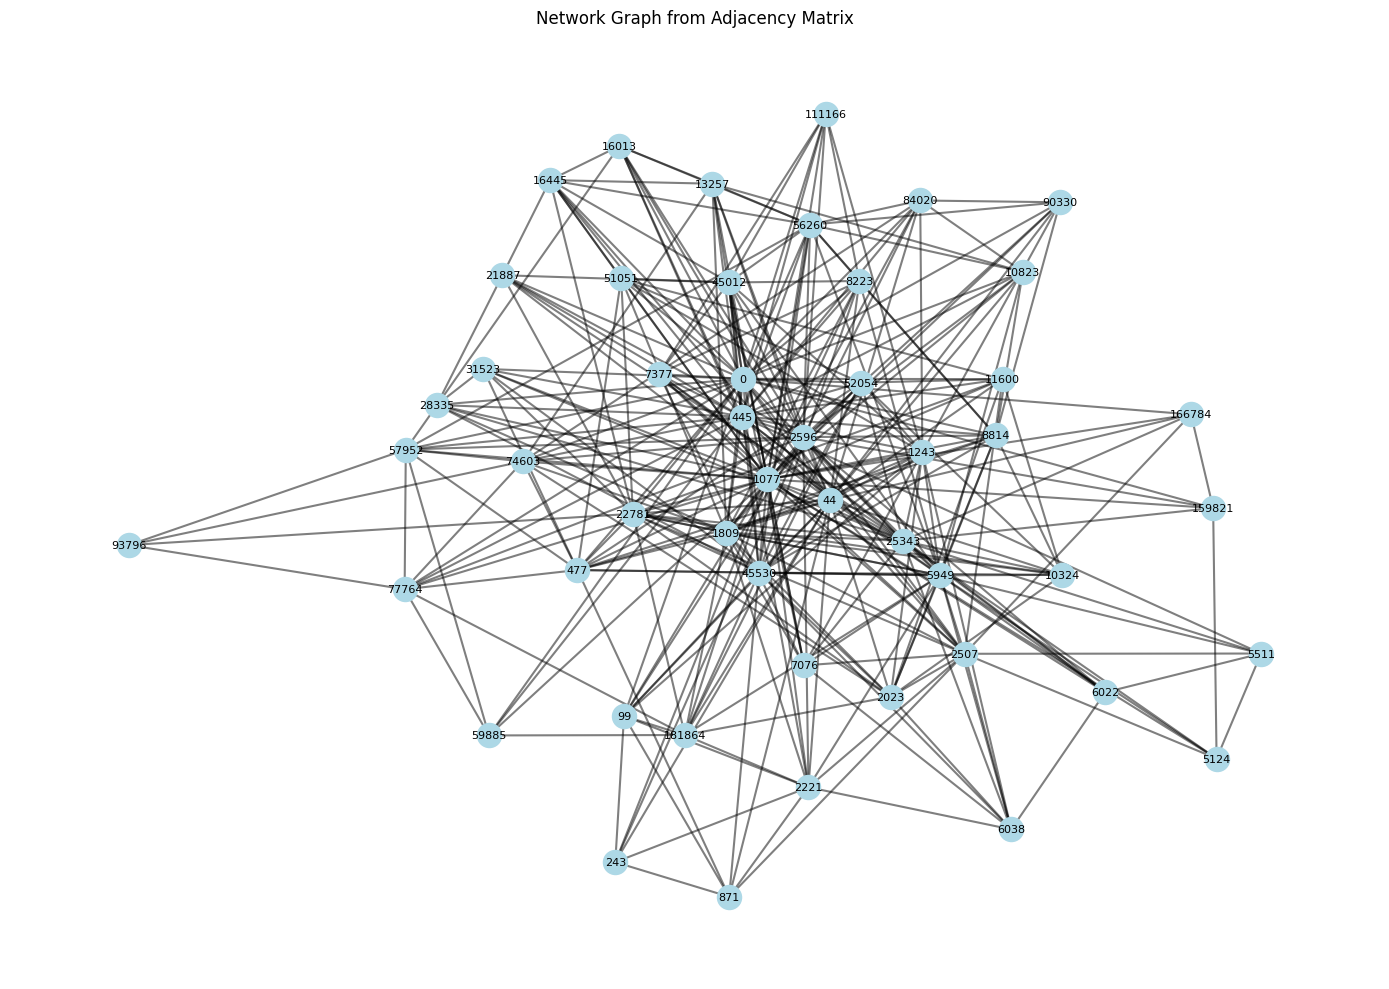

Number of nodes: 50
Number of edges: 331
Network density: 0.2702


In [20]:
# Create a NetworkX graph from the binary adjacency matrix
G = nx.from_pandas_adjacency(binary_matrix)

#Remove self-loops (diagonal values of 1)
G.remove_edges_from(nx.selfloop_edges(G))

# Visualize the network
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network Graph from Adjacency Matrix")
plt.axis('off')
plt.tight_layout()
plt.show()

# Print network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

# CCM check (matches): step size=5,  df.iloc[[94705,39836,318277], [2]] -> bins_fxd_step: (920, 925), (1895, 1900), (1915, 1920)

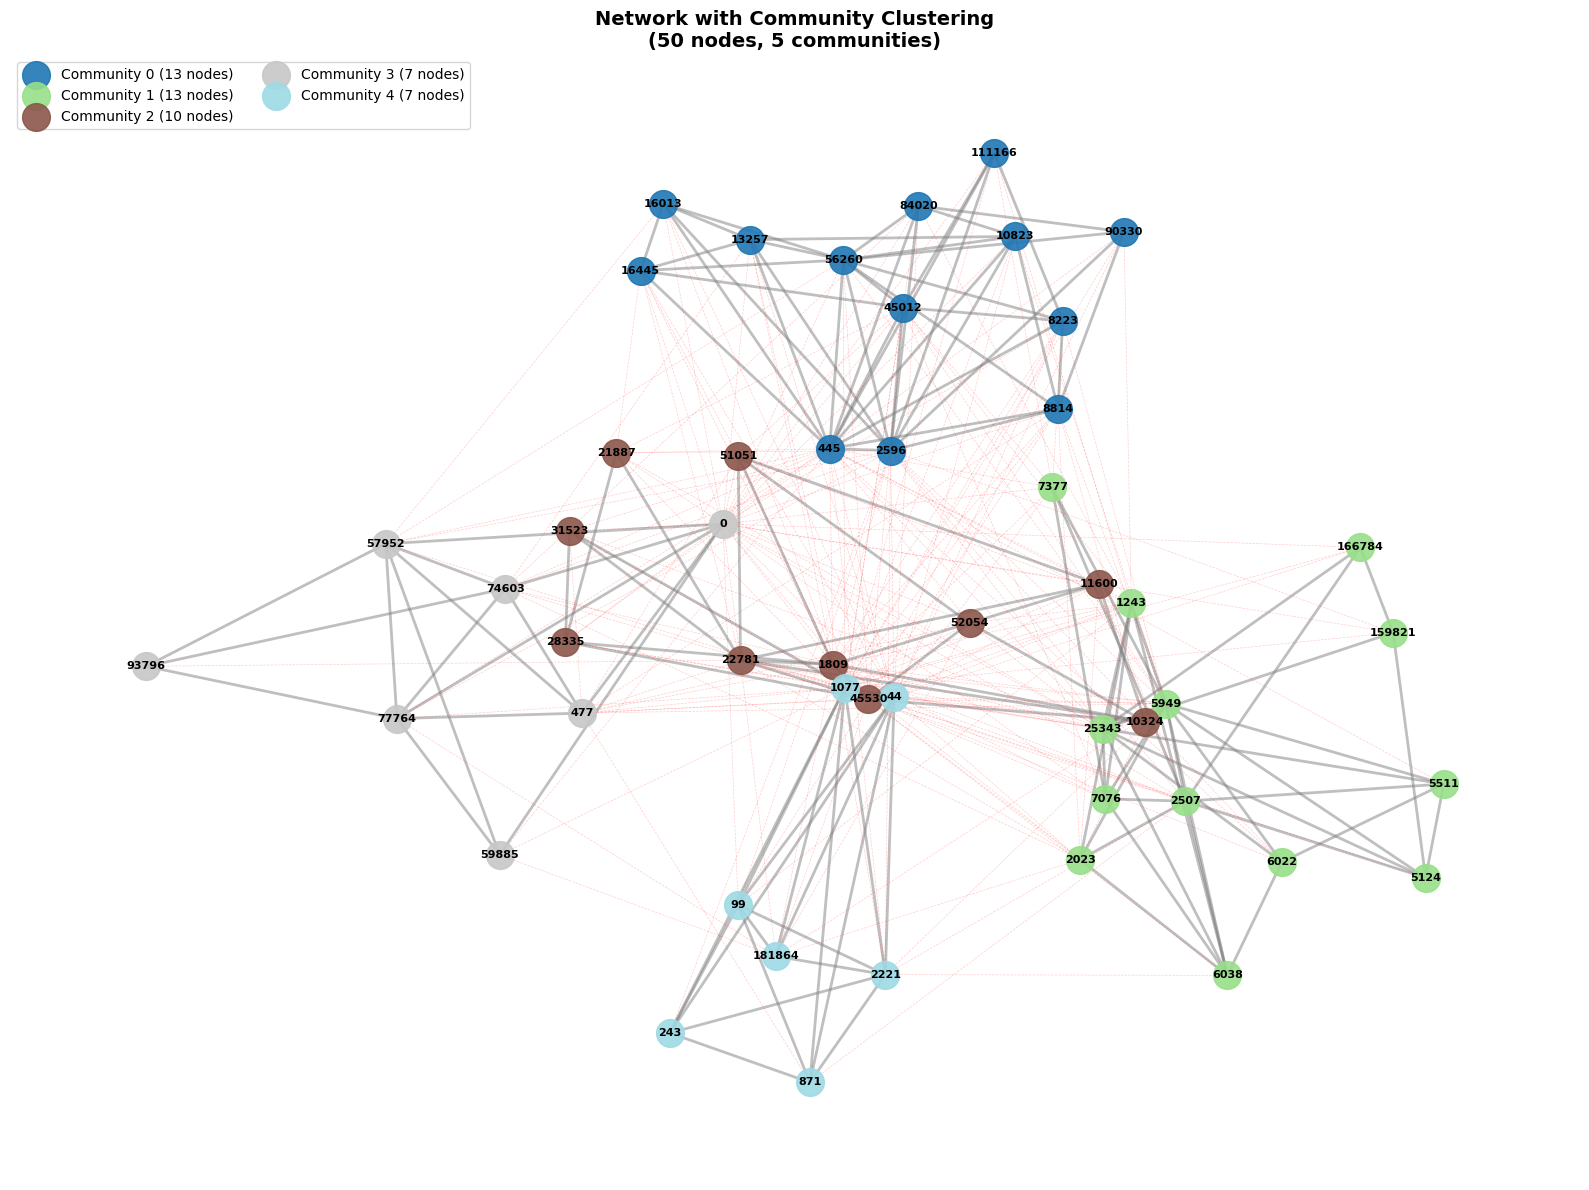

In [21]:
# Graph analysis with community detection and improved visualization

# Create graph
G = nx.from_pandas_adjacency(binary_matrix)
G.remove_edges_from(nx.selfloop_edges(G))

# Detect communities
communities_list = list(community.greedy_modularity_communities(G))

# Create node to community mapping
node_to_community = {}
for i, comm in enumerate(communities_list):
    for node in comm:
        node_to_community[node] = i

# Use spring layout with custom parameters to create tighter clusters
# Increase k to push nodes apart, but edges will pull community members together
pos = nx.spring_layout(G, k=1.0, iterations=100, seed=42, scale=2)

# Apply community-aware repositioning
# Move nodes closer to their community centroid
community_centers = {}
for i, comm in enumerate(communities_list):
    comm_nodes = list(comm)
    center_x = np.mean([pos[node][0] for node in comm_nodes])
    center_y = np.mean([pos[node][1] for node in comm_nodes])
    community_centers[i] = (center_x, center_y)

# Adjust node positions to be closer to community centers
for node in G.nodes():
    comm_id = node_to_community[node]
    center = community_centers[comm_id]
    # Move node 30% towards its community center
    pos[node] = (
        pos[node][0] * 0.7 + center[0] * 0.3,
        pos[node][1] * 0.7 + center[1] * 0.3
    )

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))

# Draw nodes colored by community (now spatially grouped)
colors = plt.cm.tab20(np.linspace(0, 1, len(communities_list)))
for i, comm in enumerate(communities_list):
    comm_nodes = list(comm)
    nx.draw_networkx_nodes(G, pos, nodelist=comm_nodes, 
                          node_color=[colors[i]], 
                          node_size=400, 
                          alpha=0.9, 
                          label=f'Community {i} ({len(comm)} nodes)',
                          ax=ax)

# Draw edges - distinguish internal vs external
internal_edges = []
external_edges = []
for u, v in G.edges():
    if node_to_community[u] == node_to_community[v]:
        internal_edges.append((u, v))
    else:
        external_edges.append((u, v))

# Draw internal edges (within communities) - darker and thicker
nx.draw_networkx_edges(G, pos, edgelist=internal_edges, 
                      alpha=0.5, width=2, 
                      edge_color='gray', ax=ax)

# Draw external edges (between communities) - lighter and thinner
nx.draw_networkx_edges(G, pos, edgelist=external_edges, 
                      alpha=0.2, width=0.5, 
                      edge_color='red', ax=ax, style='dashed')

nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)

ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.set_title(f"Network with Community Clustering\n({G.number_of_nodes()} nodes, {len(communities_list)} communities)", 
             fontsize=14, fontweight='bold')
ax.axis('off')
fig.tight_layout()
plt.show()

#### Modularity Measure

#### Randomness Control with Different Null Models

## Production Line - CSP

In [93]:
df_CSP = pd.read_csv('data/csp_manipulated_205496_rev1.csv', header=None)
pd.read_csv('data/csp_manipulated_205496_rev1.csv', names=fn.columns_CSP, header=None).head()

EVENT_ID SEQUENCE_ID  1  2  3  4  5  6  WIDTH  THICKNESS        CUT_TIME  \
0         1        1660  0  0  0  0  0  0   1240         66  30.06.17 20:11   
1         2        1660  0  0  0  0  0  0   1229         65  30.06.17 20:19   
2         3        1660  0  0  0  0  0  0   1227         65  30.06.17 20:26   
3         4        1660  0  0  0  0  0  0   1227         65  30.06.17 20:34   
4         5        1660  0  0  0  0  0  0   1227         65  30.06.17 20:41   

      SECONDS   HEAT_ID  STEEL_GRADE_ID_INT  THICKNESS_HSM  MATERIAL_ID  \
0  3707842260  17078201                  49        6.45848       239846   
1  3707842740  17078201                  49        6.27410       239847   
2  3707843160  17078201                  49        6.27613       239848   
3  3707843640  17078201                  49        6.27651       239849   
4  3707844060  17078201                  49        6.27284       239850   

      PIECE_ID  
0  17078201-01  
1  17078201-02  
2  17078201-03  
3  17078201-04  
4  17078201-05

In [95]:
data = df_CSP
features = [8,9] # input width and thickness
data[features].nunique()

8    1006
9      33
dtype: int64

## Production Line - PLTCM

In [86]:
df_PLTCM = pd.read_csv('data/pltcm_manipulated_59604_rev1.csv', header=None)
pd.read_csv('data/pltcm_manipulated_59604_rev1.csv', names=fn.columns_PLTCM, header=None).head()

EVENT_ID  PROGRAM_ID  1  2  3  4  5  6  INPUT_WIDTH  INPUT_THICKNESS  ...  \
0         1        3609  0  0  0  0  0  0    1264.0446          2.55459  ...   
1         2        3609  0  0  0  0  0  0    1129.5043          2.73491  ...   
2         3        3609  0  0  0  0  0  0    1096.1252          2.71956  ...   
3         4        3609  0  0  0  0  0  0    1129.7084          2.73506  ...   
4         5        3609  0  0  0  0  0  0    1569.3829          2.63399  ...   

  TARGET_WIDTH  THICKNESS_HSM  THICKNESS  TRIM_WIDTH      WIDTH  MATERIAL_ID  \
0    1222.6404        2.55459   0.477354     1224.67  1222.6381       318580   
1    1089.0250        2.73491   0.564271     1091.06  1089.0281       323346   
2    1057.3627        2.71956   0.614289     1059.39  1057.3580       323357   
3    1089.0250        2.73506   0.564197     1091.06  1089.0281       323344   
4    1528.7625        2.63399   0.569115     1529.56  1528.7650       318740   

         PIECE_ID    WEIGHT   LENGTH  INPUT_LENGTH  
0  17167961-03000  13.57540  2998.57     543.95600  
1  17172941-01000  21.04121  4387.14     875.23380  
2  17172961-04000  15.52353  3061.01     672.14825  
3  17172921-05000  21.02293  4386.41     875.66516  
4  17168341-04000  17.28409  2558.96     536.53850  

[5 rows x 25 columns]

In [85]:
data = df_PLTCM
features = [8,9] # input width and thickness
data[features].nunique()

8    57840
9    44486
dtype: int64

In [ ]:
trial=pd.read_csv('data/PLTCM_num.csv', header=None)
trial

### Binning Schemes

Events can be grouped with a typical value interval, the so-called binning size. Binning generation can be performed in alternative ways, allowing us to put the hypothetically created constraints into practice.

There alternative ways of binning such as fixed steps or fixed counts (buckets). The former creates binning with defined step size, the latter forms bin data into groups with equal numbers of elements.

In [7]:
data = df_PLTCM
feature = 8 # input width
df = pd.DataFrame()
df['sequence_id'] = data[1]
df[feature] = data[feature]
df['bins_fxd_step'] = fn.binning_fxd_step(data[feature], 11)
df['bins_fxd_bucket'] = fn.binning_fxd_bucket(data[feature], 85)
print('bins_fxd_step count:',df['bins_fxd_step'].nunique())
print('bins_fxd_bucket count:',df['bins_fxd_bucket'].nunique())
df
# select specific rows for testing
#df.iloc[[73,472,1213,9087], [0,2]]

bins_fxd_step count: 85
bins_fxd_bucket count: 85


sequence_id          8     bins_fxd_step bins_fxd_bucket
0             3609  1264.0446  [1258.6, 1269.6)     [1264-1265]
1             3609  1129.5043  [1126.6, 1137.6)     [1126-1132]
2             3609  1096.1252  [1093.6, 1104.6)     [1085-1097]
3             3609  1129.7084  [1126.6, 1137.6)     [1126-1132]
4             3609  1569.3829  [1566.6, 1577.6)     [1569-1570]
...            ...        ...               ...             ...
59599        22800  1261.3135  [1258.6, 1269.6)     [1260-1262]
59600        22800  1261.1356  [1258.6, 1269.6)     [1260-1262]
59601        22800  1263.5488  [1258.6, 1269.6)     [1263-1264]
59602        22800  1280.8510  [1280.6, 1291.6)     [1279-1282]
59603        22800  1287.1224  [1280.6, 1291.6)     [1285-1288]

[59604 rows x 4 columns]

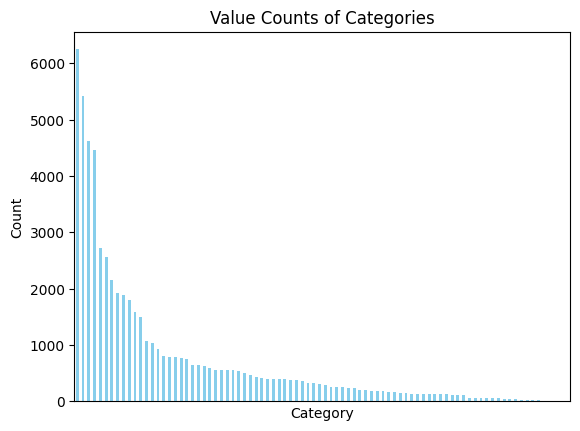

In [8]:
counts = df['bins_fxd_step'].value_counts()
#print(counts.describe())
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
#plt.yticks(range(0, max(counts)+500, 250))
plt.xticks([])
plt.title('Value Counts of Categories')
plt.show()

In [9]:
counts = df['bins_fxd_bucket'].value_counts()
print(counts.describe())
#counts.plot(kind='bar', color='skyblue')
#plt.xlabel('Category')
#plt.ylabel('Count')
#plt.yticks(range(0, max(counts)+500, 250))
#plt.xticks([])
#plt.title('Value Counts of Categories')
#plt.show()

count     85.000000
mean     701.223529
std        7.158705
min      636.000000
25%      702.000000
50%      702.000000
75%      702.000000
max      702.000000
Name: count, dtype: float64


The alternative binning generation methods mentioned above will let us derive two distinguished approaches to construct association networks.

#### Lift Measure

We extract the association rule from the set of production sequences to distinguish statistically unexpected occurrences from the non-random ones in production sequences and assess the complexity of production patterns.

The Lift can be computed as the ratio of pair items joint
probability divided by the multiplication of each item’s marginal probability as:

$$ Lift(A ↔ B) =  \frac{P(A, B)}{P(A) ∗ P(B)} $$

If the lift is higher than 1, B likely occurs when A occurs. If the lift is lower than 1, B unlikely occurs when A occurs.

In [16]:
# Calculate lift and get indices for both fixed-step bins and fixed-count buckets
lift_pairwise_step, elem_map_step = fn.calculate_lift_pairwise(df, bins_column='bins_fxd_step', return_element_mapping=True)
lift_pairwise_bucket, elem_map_bucket = fn.calculate_lift_pairwise(df, bins_column='bins_fxd_bucket', return_element_mapping=True)

# Build adjacency matrices
adj_matrix_step = fn.create_adjacency_matrix(lift_pairwise_step, elem_map_step)
adj_matrix_bucket = fn.create_adjacency_matrix(lift_pairwise_bucket, elem_map_bucket)

#lift_pairwise_step
#lift_pairwise.index.to_list()

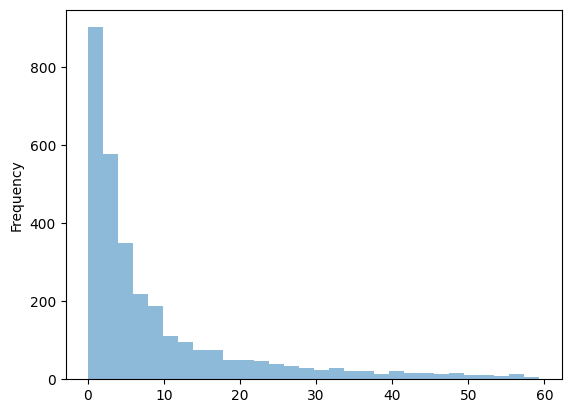

In [17]:
#histogram
ax = lift_pairwise_step['lift_value'].apply(lambda x: x if 0 < x < 60 else None).plot.hist(bins=30, alpha=0.5)

Characteristics:
- Right-Skewed, approaching zero
- Heavy concentration at low lift values (0-5)
- Long tail toward higher values
- High positive skewness (> 1.0)
- Median << Mean

What it means:
- High-Frequency Elements: Most element pairs have weak or random co-occurrence
- Most pairs have lift < 1 (appear together less often than random chance)
- A few rare pairs have strong associations
- Common elements occur independently; co-occurrence is mostly coincidental

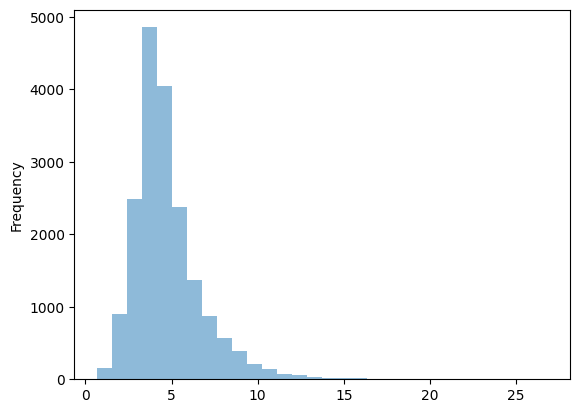

In [18]:
bx = lift_pairwise_bucket['lift_value'].apply(lambda x: x if 0 < x < 5000 else None).plot.hist(bins=30, alpha=0.5)

Characteristics:
- Near-Normal, deviation from zero
- More centered distribution (peak around 2-3)
- Roughly symmetric around the mean
- Lower skewness (-0.5 to +0.5)
- Mean ≈ Median

What it means:
- Rare/Selective Elements: Most element pairs have meaningful associations
- Lift values are concentrated around 2-4 (strong positive associations)
- More consistent clustering behavior
- Rare elements form predictable, structured groups when they co-occur

### Network Analysis

Constructing FSS (Fixed Step Size) and FBS (Fixed Bucket Size) networks for the production events concerning technology-driven constraints and load-driven constraints underlie the developed hypothesis of this work: Non-random features of the association networks derived from these two approaches.

The first one, the FSS Network has graph nodes as binning groups with equal bin sizes. Manipulation of binning size allows us to aggregate events in different network nodes. 

The FBS Network is the second one where the network nodes are binning groups with an equal number of events per bin. Defining a typical bucket size for the network nodes results in arbitrary interval boundaries for each node, and it allows to control their population.

#### Graphs Generation

In [19]:
adj_matrix_step
# select specific pair
# lift_pairwise.loc[(lift_pairwise['element_A_row_idx'] == 0) & (lift_pairwise['element_B_row_idx'] == 5)]

0          1          2          4          5            6      \
0       1.000000   0.126610   0.163488   0.055177   7.243478     2.711224   
1       0.126610   1.000000   0.589535   0.104108  20.594450     4.243680   
2       0.163488   0.589535   1.000000   0.150094   7.078833     4.375113   
4       0.055177   0.104108   0.150094   1.000000   7.214325     2.349281   
5       7.243478  20.594450   7.078833   7.214325   1.000000   275.944425   
...          ...        ...        ...        ...        ...          ...   
13191   0.575741   0.319200   0.594180   0.978164  65.141000     5.428400   
15184  94.672750  89.866567  84.946300  26.637450   0.000000  1103.777800   
15259   3.832921   7.632900  15.609800  10.764273   0.000000   127.359000   
15566  21.494300   2.643100   3.331200   8.022580   0.000000     0.000000   
30000   4.235340   1.872200   4.719200   5.993437   0.000000     0.000000   

            7          8          13          14     ...       6585   \
0        1.171064   0.222892   0.064400    0.296319  ...    0.794165   
1        5.797854   0.657925   0.139816    1.128944  ...    1.697376   
2        7.124540   0.413793   0.205579    1.428879  ...    3.272315   
4        1.608057   0.284048   0.060672    0.387064  ...    0.904758   
5      170.239900  18.373600   6.838178   31.086925  ...   70.620850   
...           ...        ...        ...         ...  ...         ...   
13191    7.880000   2.630550   0.607440    1.630800  ...    7.100700   
15184    0.000000  48.996300  14.855400  276.328200  ...  188.322300   
15259    0.000000  11.306833   2.816008   15.486514  ...   43.459000   
15566    0.000000  17.292800   9.587300    0.000000  ...    0.000000   
30000    0.000000  26.029300   6.366580    0.000000  ...    0.000000   

           8553      8636        9087        11931       13191        15184  \
0       1.542305   16.6093   20.346350    1.647842    0.575741    94.672750   
1       3.086633    0.0000    5.616700    8.786167    0.319200    89.866567   
2       3.749880    9.4385    0.000000    6.354250    0.594180    84.946300   
4       1.780874   23.0858   22.071043    1.132625    0.978164    26.637450   
5      83.902000    0.0000  620.875000  107.553175   65.141000     0.000000   
...          ...       ...         ...         ...         ...          ...   
13191  19.806400   65.1410  195.423000   11.540700    1.000000     0.000000   
15184   0.000000    0.0000    0.000000    0.000000    0.000000     1.000000   
15259  77.448000    0.0000  859.673100   54.152600  176.632250  1528.307700   
15566   0.000000    0.0000    0.000000    0.000000   34.486400     0.000000   
30000   0.000000  827.8333  620.875000  117.330700   56.998375     0.000000   

             15259     15566       30000  
0         3.832921  21.49430    4.235340  
1         7.632900   2.64310    1.872200  
2        15.609800   3.33120    4.719200  
4        10.764273   8.02258    5.993437  
5         0.000000   0.00000    0.000000  
...            ...       ...         ...  
13191   176.632250  34.48640   56.998375  
15184  1528.307700   0.00000    0.000000  
15259     1.000000   0.00000  668.634600  
15566     0.000000   1.00000    0.000000  
30000   668.634600   0.00000    1.000000  

[85 rows x 85 columns]

In [20]:
# Convert values: <1 → 0, >1 → 1
# Values exactly equal to 1 (diagonal/no connection) remain 0
binary_matrix = adj_matrix_step.copy()
binary_matrix[binary_matrix < 1] = 0
binary_matrix[binary_matrix > 1] = 1
binary_matrix

0      1      2      4      5      6      7      8      13     14     \
0        1.0    0.0    0.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0   
1        0.0    1.0    0.0    0.0    1.0    1.0    1.0    0.0    0.0    1.0   
2        0.0    0.0    1.0    0.0    1.0    1.0    1.0    0.0    0.0    1.0   
4        0.0    0.0    0.0    1.0    1.0    1.0    1.0    0.0    0.0    0.0   
5        1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
13191    0.0    0.0    0.0    0.0    1.0    1.0    1.0    1.0    0.0    1.0   
15184    1.0    1.0    1.0    1.0    0.0    1.0    0.0    1.0    1.0    1.0   
15259    1.0    1.0    1.0    1.0    0.0    1.0    0.0    1.0    1.0    1.0   
15566    1.0    1.0    1.0    1.0    0.0    0.0    0.0    1.0    1.0    0.0   
30000    1.0    1.0    1.0    1.0    0.0    0.0    0.0    1.0    1.0    0.0   

       ...  6585   8553   8636   9087   11931  13191  15184  15259  15566  \
0      ...    0.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0   
1      ...    1.0    1.0    0.0    1.0    1.0    0.0    1.0    1.0    1.0   
2      ...    1.0    1.0    1.0    0.0    1.0    0.0    1.0    1.0    1.0   
4      ...    0.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0    1.0   
5      ...    1.0    1.0    0.0    1.0    1.0    1.0    0.0    0.0    0.0   
...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
13191  ...    1.0    1.0    1.0    1.0    1.0    1.0    0.0    1.0    1.0   
15184  ...    1.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0    0.0   
15259  ...    1.0    1.0    0.0    1.0    1.0    1.0    1.0    1.0    0.0   
15566  ...    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    1.0   
30000  ...    0.0    0.0    1.0    1.0    1.0    1.0    0.0    1.0    0.0   

       30000  
0        1.0  
1        1.0  
2        1.0  
4        1.0  
5        0.0  
...      ...  
13191    1.0  
15184    0.0  
15259    1.0  
15566    0.0  
30000    1.0  

[85 rows x 85 columns]

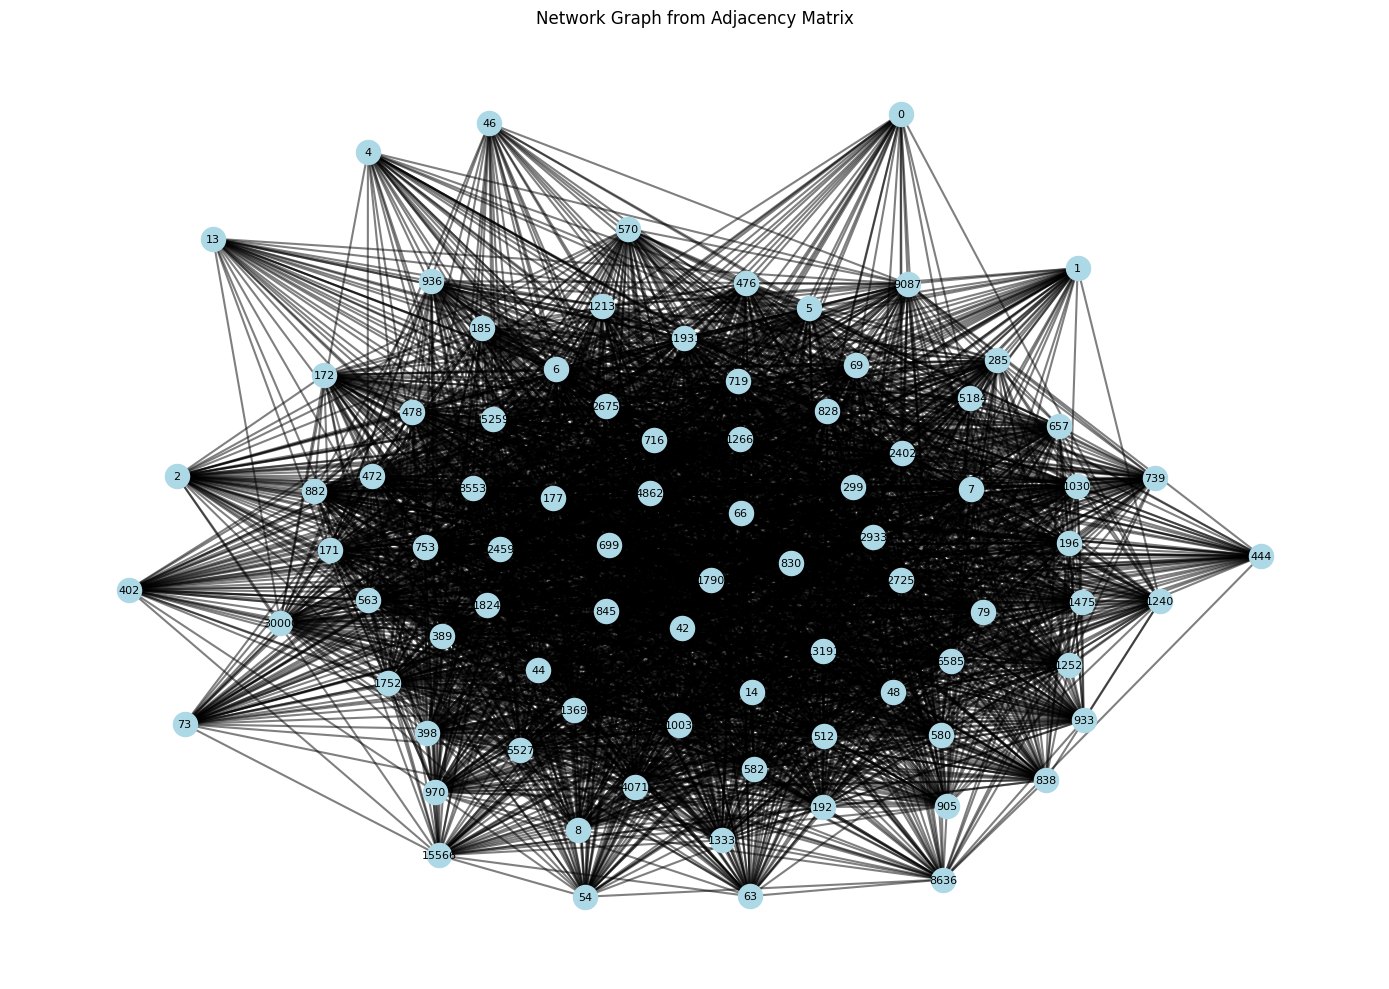

Number of nodes: 85
Number of edges: 2901
Network density: 0.8126


In [21]:
# Create a NetworkX graph from the binary adjacency matrix
G = nx.from_pandas_adjacency(binary_matrix)

#Remove self-loops (diagonal values of 1)
G.remove_edges_from(nx.selfloop_edges(G))

# Visualize the network
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Network Graph from Adjacency Matrix")
plt.axis('off')
plt.tight_layout()
plt.show()

# Print network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Network density: {nx.density(G):.4f}")

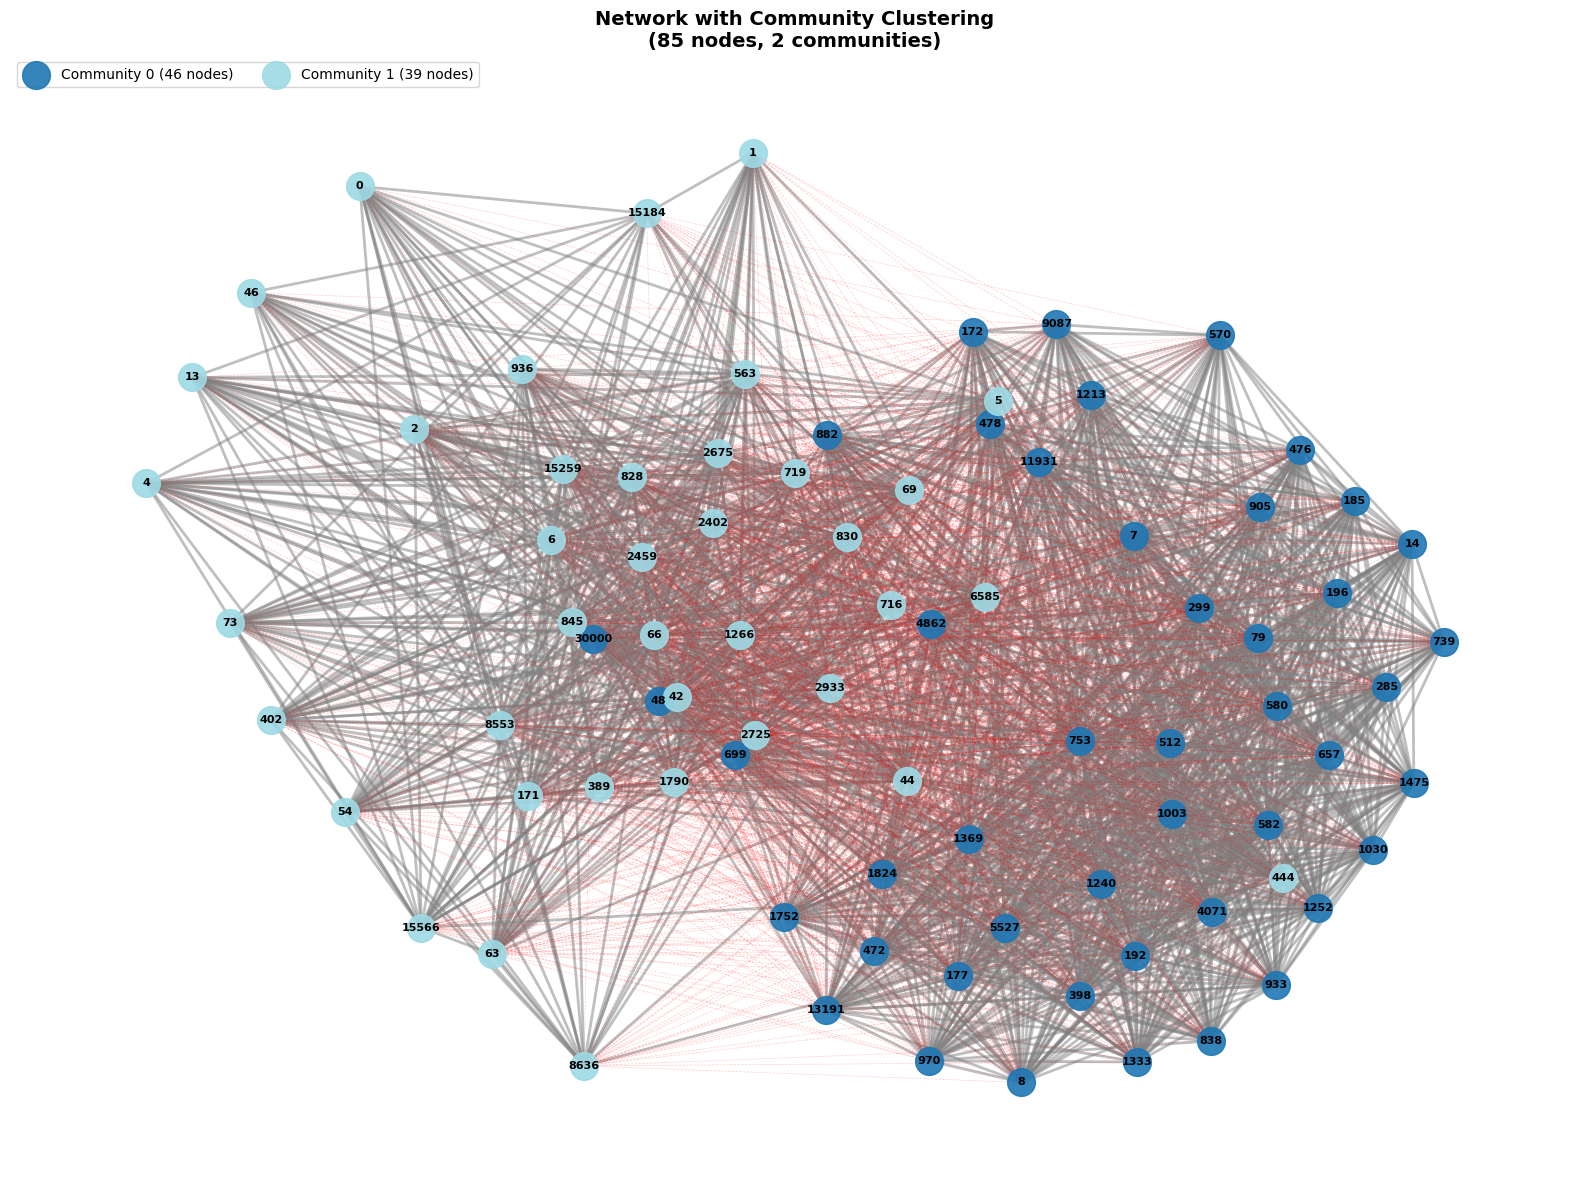

In [22]:
# Graph analysis with community detection and improved visualization

# Create graph
G = nx.from_pandas_adjacency(binary_matrix)
G.remove_edges_from(nx.selfloop_edges(G))

# Detect communities
communities_list = list(community.greedy_modularity_communities(G))

# Create node to community mapping
node_to_community = {}
for i, comm in enumerate(communities_list):
    for node in comm:
        node_to_community[node] = i

# Use spring layout with custom parameters to create tighter clusters
# Increase k to push nodes apart, but edges will pull community members together
pos = nx.spring_layout(G, k=1.0, iterations=100, seed=42, scale=2)

# Apply community-aware repositioning
# Move nodes closer to their community centroid
community_centers = {}
for i, comm in enumerate(communities_list):
    comm_nodes = list(comm)
    center_x = np.mean([pos[node][0] for node in comm_nodes])
    center_y = np.mean([pos[node][1] for node in comm_nodes])
    community_centers[i] = (center_x, center_y)

# Adjust node positions to be closer to community centers
for node in G.nodes():
    comm_id = node_to_community[node]
    center = community_centers[comm_id]
    # Move node 30% towards its community center
    pos[node] = (
        pos[node][0] * 0.7 + center[0] * 0.3,
        pos[node][1] * 0.7 + center[1] * 0.3
    )

# Visualize
fig, ax = plt.subplots(figsize=(16, 12))

# Draw nodes colored by community (now spatially grouped)
colors = plt.cm.tab20(np.linspace(0, 1, len(communities_list)))
for i, comm in enumerate(communities_list):
    comm_nodes = list(comm)
    nx.draw_networkx_nodes(G, pos, nodelist=comm_nodes, 
                          node_color=[colors[i]], 
                          node_size=400, 
                          alpha=0.9, 
                          label=f'Community {i} ({len(comm)} nodes)',
                          ax=ax)

# Draw edges - distinguish internal vs external
internal_edges = []
external_edges = []
for u, v in G.edges():
    if node_to_community[u] == node_to_community[v]:
        internal_edges.append((u, v))
    else:
        external_edges.append((u, v))

# Draw internal edges (within communities) - darker and thicker
nx.draw_networkx_edges(G, pos, edgelist=internal_edges, 
                      alpha=0.5, width=2, 
                      edge_color='gray', ax=ax)

# Draw external edges (between communities) - lighter and thinner
nx.draw_networkx_edges(G, pos, edgelist=external_edges, 
                      alpha=0.2, width=0.5, 
                      edge_color='red', ax=ax, style='dashed')

nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)

ax.legend(loc='upper left', fontsize=10, ncol=2)
ax.set_title(f"Network with Community Clustering\n({G.number_of_nodes()} nodes, {len(communities_list)} communities)", 
             fontsize=14, fontweight='bold')
ax.axis('off')
fig.tight_layout()
plt.show()

#### Modularity Measure

#### Randomness Control with Different Null Models

## Production Line - CGL

In [89]:
df_CGL = pd.read_csv('data/cgl_manipulated_27147_rev1.csv', header=None)
pd.read_csv('data/cgl_manipulated_27147_rev1.csv', names=fn.columns_CGL, header=None).head()

EVENT_ID  PROGRAM_ID  1  STEEL_GRADE_ID_INT  WIDTH_R  THICKNESS_R  WEIGHT  \
0         1        3712  0                  26    951.0         0.49  15.688   
1         2        3712  0                  26    950.0         0.51  15.886   
2         3        3712  0                  26    950.0         0.50  15.840   
3         4        3712  0                  26    951.0         0.52  15.847   
4         5        3712  0                  26    951.0         0.52  15.850   

      LENGTH      WIDTH  THICKNESS                                CUT_DATE  \
0  4289.3130  950.07294   0.485686  10-JAN-18 07.28.57.000000000 AM -06:00   
1  4177.5107  950.07294   0.485930  10-JAN-18 07.59.01.000000000 AM -06:00   
2  4248.7220  950.07294   0.485982  10-JAN-18 08.29.00.000000000 AM -06:00   
3  4083.0000  950.07294   0.486016  10-JAN-18 08.58.55.000000000 AM -06:00   
4  4083.5903  950.07294   0.486041  10-JAN-18 09.27.54.000000000 AM -06:00   

      SECONDS  
0  3724579737  
1  3724581541  
2  3724583340  
3  3724585135  
4  3724586874

In [90]:
data = df_CGL
features = [8,9] # input width and thickness
data[features].nunique()

8     2481
9    25008
dtype: int64